In [4]:
# Get bitcoin data from GeckoAPI
from pycoingecko import CoinGeckoAPI
from datetime import datetime 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

import requests
from pathlib import Path

## Use API to gather data.

In [5]:
cg = CoinGeckoAPI()

# Get previous prices (1 yr + 1 day)
data = cg.get_coin_market_chart_by_id(id='bitcoin', vs_currency='usd', days='366', interval='daily')

# keys of data dictionary.
data.keys()

dict_keys(['prices', 'market_caps', 'total_volumes'])

## Bitcoin dataframe

In [6]:
# Create Bitcoin data frame based on the dictionary from cg api.
bitcoin_df = pd.DataFrame()

bitcoin_df['Date'] = pd.DataFrame(data['prices'])[0]
bitcoin_df['Price'] = pd.DataFrame(data['prices'])[1]
bitcoin_df['Total_Vols'] = pd.DataFrame(data['total_volumes'])[1]
bitcoin_df['Market Cap'] = pd.DataFrame(data['market_caps'])[1]

bitcoin_df

,Date,Price,Total_Vols,Market Cap
0,1593216000000,9166.486360,2.242920e+10,1.688071e+11
1,1593302400000,9013.905565,2.151563e+10,1.660050e+11
2,1593388800000,9139.903276,1.966594e+10,1.683340e+11
3,1593475200000,9185.166541,1.975446e+10,1.691759e+11
4,1593561600000,9149.721997,1.974144e+10,1.685587e+11
...,...,...,...,...
362,1624492800000,33702.617794,3.979824e+10,6.316348e+11
363,1624579200000,34675.449105,3.186205e+10,6.503405e+11
364,1624665600000,31943.136468,3.863525e+10,5.987030e+11
365,1624752000000,32023.973902,3.687311e+10,6.002353e+11


In [7]:
# Clean data format
# Unix timestamp -> utc format
bitcoin_df['Date'] = bitcoin_df['Date'].apply(lambda x: datetime.utcfromtimestamp(int(x) / 1000).strftime('%Y-%m-%d'))

# Show only 2 decimals (will not modify actual value)
pd.options.display.float_format = "{:,.2f}".format
bitcoin_df

,Date,Price,Total_Vols,Market Cap
0,2020-06-27,"9,166.49","22,429,204,010.64","168,807,143,703.19"
1,2020-06-28,"9,013.91","21,515,626,881.10","166,004,979,429.80"
2,2020-06-29,"9,139.90","19,665,935,216.70","168,334,049,772.47"
3,2020-06-30,"9,185.17","19,754,459,582.75","169,175,896,894.16"
4,2020-07-01,"9,149.72","19,741,435,780.49","168,558,715,595.08"
...,...,...,...,...
362,2021-06-24,"33,702.62","39,798,236,962.44","631,634,847,766.23"
363,2021-06-25,"34,675.45","31,862,051,544.35","650,340,461,975.81"
364,2021-06-26,"31,943.14","38,635,245,431.36","598,703,019,611.45"
365,2021-06-27,"32,023.97","36,873,109,419.90","600,235,334,320.82"


In [8]:
# Create new column indicating price change from previous day
bitcoin_df['Difference ($)'] = bitcoin_df['Price'] - bitcoin_df['Price'].shift(periods = 1)

# Create new column indicating price change in percentage from previous day
bitcoin_df['Difference (%)'] = (1 - bitcoin_df['Price'].shift(periods = 1) / bitcoin_df['Price']) * 100 

# Create new column indicating price change in percentage from previous day
bitcoin_df['Volume Change (%)'] = (1 - bitcoin_df['Total_Vols'].shift(periods = 1) / bitcoin_df['Total_Vols']) * 100 

bitcoin_df.dropna(inplace=True)

# Boolean value of whether price whent up.
# 0 change is considered 'up', since there will be no loss of profit.
bitcoin_df['Up'] = bitcoin_df['Difference ($)'].apply(lambda x: True if x >= 0 else False).shift(periods = -1)

bitcoin_df.dropna(inplace=True)

bitcoin_df.head(10)

,Date,Price,Total_Vols,Market Cap,Difference ($),Difference (%),Volume Change (%),Up
1,2020-06-28,"9,013.91","21,515,626,881.10","166,004,979,429.80",-152.58,-1.69,-4.25,True
2,2020-06-29,"9,139.90","19,665,935,216.70","168,334,049,772.47",126.00,1.38,-9.41,True
3,2020-06-30,"9,185.17","19,754,459,582.75","169,175,896,894.16",45.26,0.49,0.45,False
4,2020-07-01,"9,149.72","19,741,435,780.49","168,558,715,595.08",-35.44,-0.39,-0.07,True
5,2020-07-02,"9,230.67","20,005,031,554.02","170,031,996,602.77",80.95,0.88,1.32,False
6,2020-07-03,"9,094.32","19,379,463,385.30","167,604,994,105.35",-136.35,-1.50,-3.23,False
7,2020-07-04,"9,071.39","17,420,495,829.39","167,116,284,671.22",-22.93,-0.25,-11.25,True
8,2020-07-05,"9,132.91","16,643,732,672.69","168,258,822,207.30",61.52,0.67,-4.67,False
9,2020-07-06,"9,087.41","17,324,463,886.38","167,429,736,492.90",-45.50,-0.50,3.93,True
10,2020-07-07,"9,342.38","21,987,059,041.69","172,136,257,752.37",254.97,2.73,21.21,False


## Bitcoin consecutive movement Data Frame

In [9]:
# Trend of consecutive movement
# Total amount of change in both amount and percentage during each consecutive movement

ls = []
count = 0
prev = None
amount = None
b_price = None

for index, row in bitcoin_df.iterrows():
    i = row['Up']
    t = row["Difference ($)"]
    p = row["Price"]
    
    if i == prev:
        count+=1
        amount += t
        
    else:
        ls.append([("Up" if prev else "Down"), count, amount, (None if amount==None else amount/b_price*100)])
        prev = i
        count = 1
        amount = t
        b_price = p
        
bitcoint_trend_df = pd.DataFrame(ls).rename(columns={0: "Up/Down", 1: "# of days", 2: "Amount ($)", 3: "Amount (%)"})

bitcoint_trend_df.dropna(inplace=True)

bitcoint_trend_df

,Up/Down,# of days,Amount ($),Amount (%)
1,Up,2,-26.58,-0.29
2,Down,1,45.26,0.49
3,Up,1,-35.44,-0.39
4,Down,2,-55.40,-0.60
5,Up,1,-22.93,-0.25
...,...,...,...,...
204,Down,5,"-3,266.59",-8.04
205,Up,1,-299.47,-0.84
206,Down,1,205.44,0.57
207,Up,3,"-2,084.46",-6.57


In [10]:
# Looping to gether data from api and get daily maximum and minimum


# Find correlation among Total Vol, Price change, consecutive movement.
# Need more data 5 yrs
# 

## Bitcoin Price Data Frame

In [11]:
bitcoin_price_df =  bitcoin_df[["Date","Price"]]
bitcoin_price_df

,Date,Price
1,2020-06-28,"9,013.91"
2,2020-06-29,"9,139.90"
3,2020-06-30,"9,185.17"
4,2020-07-01,"9,149.72"
5,2020-07-02,"9,230.67"
...,...,...
361,2021-06-23,"32,507.74"
362,2021-06-24,"33,702.62"
363,2021-06-25,"34,675.45"
364,2021-06-26,"31,943.14"


In [12]:
pre_three_days_average = []
pre_seven_days_average = []
pre_thirty_days_average = []
post_three_days_average = []
post_seven_days_average = []

for i in range(len(bitcoin_df)):
    pre_three_average = np.mean(bitcoin_df[i-3:i+1]['Price'])
    pre_three_days_average.append(pre_three_average)
    
    pre_seven_average = np.mean(bitcoin_df[i-7:i+1]['Price'])
    pre_seven_days_average.append(pre_seven_average)
    
    pre_thirty_average = np.mean(bitcoin_df[i-30:i+1]['Price'])
    pre_thirty_days_average.append(pre_thirty_average)
    
    post_three_average = np.mean(bitcoin_df[i:i+4]['Price'])
    post_three_days_average.append(post_three_average)
    
    post_seven_average = np.mean(bitcoin_df[i:i+8]['Price'])
    post_seven_days_average.append(post_seven_average)
    
    
bitcoin_price_df["Pre 3 days Mean"] = pd.DataFrame(pre_three_days_average)
bitcoin_price_df["Pre 7 days Mean"] = pd.DataFrame(pre_seven_days_average)
bitcoin_price_df["Pre 30 days Mean"] = pd.DataFrame(pre_thirty_days_average)
bitcoin_price_df["Post 3 days Mean"] = pd.DataFrame(post_three_days_average)
bitcoin_price_df["Post 7 days Mean"] = pd.DataFrame(post_seven_days_average)

#bitcoin_price_df.dropna(inplace=True)
bitcoin_price_df

,Date,Price,Pre 3 days Mean,Pre 7 days Mean,Pre 30 days Mean,Post 3 days Mean,Post 7 days Mean
1,2020-06-28,"9,013.91",nan,nan,nan,"9,176.37","9,136.44"
2,2020-06-29,"9,139.90",nan,nan,nan,"9,164.97","9,161.74"
3,2020-06-30,"9,185.17","9,122.17",nan,nan,"9,136.52","9,170.30"
4,2020-07-01,"9,149.72","9,176.37",nan,nan,"9,132.32","9,205.61"
5,2020-07-02,"9,230.67","9,164.97",nan,nan,"9,096.50","9,206.24"
...,...,...,...,...,...,...,...
361,2021-06-23,"32,507.74","33,427.34","35,210.90","36,662.57","33,086.29","33,086.29"
362,2021-06-24,"33,702.62","33,149.44","34,755.15","36,534.61","32,880.85","32,880.85"
363,2021-06-25,"34,675.45","33,207.24","33,973.84","36,332.42","31,983.56","31,983.56"
364,2021-06-26,"31,943.14","33,086.29","33,491.70","36,094.26","32,023.97","32,023.97"


# Simple Visualization

In [13]:
bitcoin_df

,Date,Price,Total_Vols,Market Cap,Difference ($),Difference (%),Volume Change (%),Up
1,2020-06-28,"9,013.91","21,515,626,881.10","166,004,979,429.80",-152.58,-1.69,-4.25,True
2,2020-06-29,"9,139.90","19,665,935,216.70","168,334,049,772.47",126.00,1.38,-9.41,True
3,2020-06-30,"9,185.17","19,754,459,582.75","169,175,896,894.16",45.26,0.49,0.45,False
4,2020-07-01,"9,149.72","19,741,435,780.49","168,558,715,595.08",-35.44,-0.39,-0.07,True
5,2020-07-02,"9,230.67","20,005,031,554.02","170,031,996,602.77",80.95,0.88,1.32,False
...,...,...,...,...,...,...,...,...
361,2021-06-23,"32,507.74","57,443,014,757.92","606,580,031,922.72",795.80,2.45,9.70,True
362,2021-06-24,"33,702.62","39,798,236,962.44","631,634,847,766.23","1,194.88",3.55,-44.34,True
363,2021-06-25,"34,675.45","31,862,051,544.35","650,340,461,975.81",972.83,2.81,-24.91,False
364,2021-06-26,"31,943.14","38,635,245,431.36","598,703,019,611.45","-2,732.31",-8.55,17.53,True


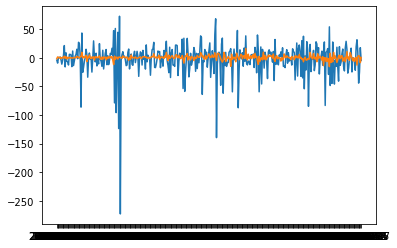

In [14]:
plt.plot(bitcoin_df['Date'], bitcoin_df['Volume Change (%)'])
plt.plot(bitcoin_df['Date'], bitcoin_df['Difference (%)'])
plt.margins(0.05) 
plt.show()

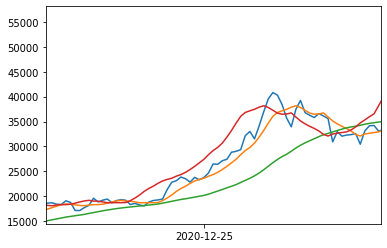

In [15]:
plt.plot(bitcoin_df['Date'], bitcoin_price_df['Price'])
#plt.plot(bitcoin_df['Date'], bitcoin_price_df['Pre 3 days Mean'])
plt.plot(bitcoin_df['Date'], bitcoin_price_df['Pre 7 days Mean']) # Orange
plt.plot(bitcoin_df['Date'], bitcoin_price_df['Pre 30 days Mean']) # Green
#plt.plot(bitcoin_df['Date'], bitcoin_price_df['Post 3 days Mean'])
plt.plot(bitcoin_df['Date'], bitcoin_price_df['Post 7 days Mean']) # Red
plt.xticks(np.arange(0, len(bitcoin_price_df['Date']) - 1, 90))
plt.margins(x=-0.4, y=-.1)
plt.show()

# Prediction and Accuracy

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model = LinearRegression()

Prediction based on Price :  -0.02091801963210571


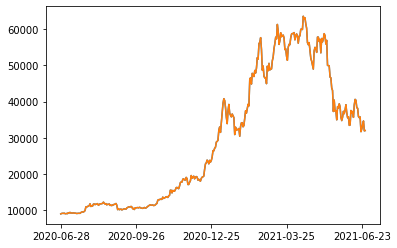

Prediction based on Total_Vols :  0.033120919456586684


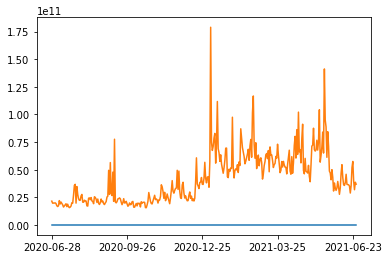

Prediction based on Market Cap :  -0.021066830940966286


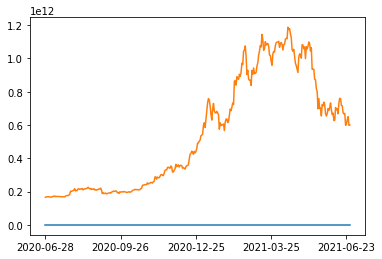

Prediction based on Difference ($) :  -0.03791700131713349


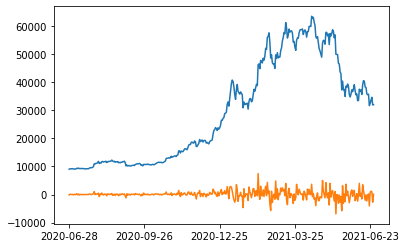

Prediction based on Difference (%) :  -0.0250264305379726


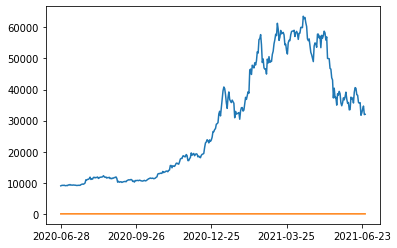

Prediction based on Volume Change (%) :  -0.00010200576665742034


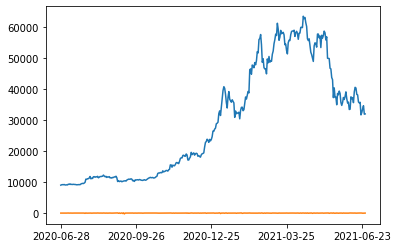

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

for i in bitcoin_df.columns:
    if (i == "Date") | (i == "Up"):
        continue
    X = bitcoin_df[[i]]
    Y = bitcoin_df['Up']
    
    tr_x, ts_x = train_test_split(X, test_size=0.1, random_state=43)
    tr_y, ts_y = train_test_split(Y, test_size=0.1, random_state=43)
    
    model = LinearRegression()
    model = model.fit(tr_x, tr_y)
    #model = model.fit(ts_x, ts_y)
    r_sq = model.score(ts_x, ts_y)

    print("Prediction based on " + i + " : ", r_sq)
    
    plt.plot(bitcoin_df['Date'], bitcoin_df['Price'])
    plt.plot(bitcoin_df['Date'], bitcoin_df[i])
    plt.xticks(np.arange(0, len(bitcoin_df['Date']) - 1, 90))
    plt.show()